In [648]:
import numpy as np
import pandas as pd
import pickle
import os
from copy import deepcopy
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, models

import matplotlib.pyplot as plt
import seaborn as sns

In [636]:
adata = pickle.load(open('odata_NANDiterate.pkl','rb'))

# adata with normalized X
# (TODO)
scaler = StandardScaler()
scaler.fit(adata.X)
adata.X = scaler.transform(adata.X)

# normalize each of the continuous covariates (the circuit genes will already have been normalized)

In [640]:
X = torch.tensor(adata.X[:,0:-9]).type(torch.float) # host gene transcriptomics (already log1p'd)

In [651]:
def MinMaxScale(arr):
    scaler = MinMaxScaler()
    scaler.fit(arr)
    return scaler.transform(arr)

In [652]:
# continuous perturbations (circuit gene expression, time, IPTG_dose, Ara_dose)
pert = adata.X[:,-9:] # circuit genes (already log1p'd and standardized)
times = adata.obs.timepoint.astype(np.float32).values.reshape(-1,1)
times = MinMaxScale(times)
iptg = adata.obs.IPTG_concentration.astype(np.float32).values.reshape(-1,1)
iptg = MinMaxScale(iptg)
ara = adata.obs.arabinose_concentration.astype(np.float32).values.reshape(-1,1)
ara = MinMaxScale(ara)
pert = np.concatenate((pert,times,iptg,ara),axis=1)
pert = torch.tensor(pert).type(torch.float)

In [5]:
# discrete covariates (wild-type, synthetic genome, synthetic plasmid)
# can later possibly expand to individual sub-strains, 
# though this would defeat the purpose of modeling the circuit gene expressions

In [654]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dims):
        super(Encoder, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    
class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dims):
        super(Decoder, self).__init__()
        
        self.fc1 = nn.Linear(hidden_dims[1], hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], output_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    
class PertEmbedder(nn.Module):
    '''
    We now want to add in the effect of the perturbations on the basal state. 
    Almost analogous to sDMD, we will do this using a nonlinear function and assume 
    that the perturbation impact is linear in the latent space. 
    '''
    def __init__(self, pert_dim, basal_dim):
        super(PertEmbedder, self).__init__()
        
        self.fc1 = nn.Linear(pert_dim, pert_dim)
        self.fc2 = nn.Linear(pert_dim, basal_dim)
        
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x
    
    
class Autoencoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dims, pert_dim):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dims)
        self.decoder = Decoder(input_dim, hidden_dims)
        self.pertembedder = PertEmbedder(pert_dim, hidden_dims[-1])
        
    def forward(self, x, p): # p is the vector of perturbations
        x = self.encoder(x)
        x = x + self.pertembedder(p)
        x = self.decoder(x)
        return x
    
    
class Discriminator(nn.Module):
    '''
    Takes in basal state and uses it to predict the continuous perturbation vector. 
    The goal is to have the discriminator do no better than guessing, meaning that the 
    basal state contains little to no information about the perturbations. 
    '''
    def __init__(self, input_dim, pert_dim):
        super(Discriminator, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, 16)
        self.fc2 = nn.Linear(16, pert_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        

In [684]:
torch.manual_seed(42);

input_dim = X.shape[1]
pert_dim = pert.shape[1]
hidden_dim = 128
basal_dim = 2

ae = Autoencoder(input_dim, [hidden_dim, basal_dim], pert_dim)
discrim = Discriminator(basal_dim, pert_dim)

criterion = nn.MSELoss()

ae_optimizer = torch.optim.Adadelta(ae.parameters(),lr=3)
discrim_optimizer = torch.optim.Adadelta(discrim.parameters())

In [685]:
# one batch equals all data for now
# Iteratively train the discriminator, then the autoencoder
EPOCHS = 5000
lam = 0.3
loss = {'recon':[],'discrimination':[]}
for epoch in range(EPOCHS):
    
    # train the discriminator
    discrim_optimizer.zero_grad()           
    Z = ae.encoder(X)            
    pert_hat = discrim(Z)
    discrim_loss = criterion(pert_hat, pert)  
    discrim_loss.backward(retain_graph=True)                 
    
    # train the autoencoder and pertembedder
    ae_optimizer.zero_grad()
    X_hat = ae(X,pert)
    ae_loss = criterion(X_hat, X) 
    total_loss = ae_loss - lam * discrim_loss
    total_loss.backward()
    
    discrim_optimizer.step()
    ae_optimizer.step()
    
    if epoch % 100 == 0: 
        print(f'EPOCH: {epoch}, D_LOSS: {discrim_loss.item()}, X_LOSS: {ae_loss.item()}')

EPOCH: 0, D_LOSS: 0.8197652101516724, X_LOSS: 0.8692348003387451
EPOCH: 100, D_LOSS: 0.766705334186554, X_LOSS: 0.5768166780471802
EPOCH: 200, D_LOSS: 0.7487463355064392, X_LOSS: 0.4074920415878296
EPOCH: 300, D_LOSS: 0.7370967268943787, X_LOSS: 0.3378530740737915
EPOCH: 400, D_LOSS: 0.7409068942070007, X_LOSS: 0.3214888572692871
EPOCH: 500, D_LOSS: 0.73734450340271, X_LOSS: 0.3164452314376831
EPOCH: 600, D_LOSS: 0.7351503968238831, X_LOSS: 0.30968552827835083
EPOCH: 700, D_LOSS: 0.7406820058822632, X_LOSS: 0.30980339646339417
EPOCH: 800, D_LOSS: 0.7358044981956482, X_LOSS: 0.3048401474952698
EPOCH: 900, D_LOSS: 0.7452999949455261, X_LOSS: 0.3064700961112976
EPOCH: 1000, D_LOSS: 0.7422611117362976, X_LOSS: 0.30287182331085205
EPOCH: 1100, D_LOSS: 0.739362895488739, X_LOSS: 0.29899823665618896
EPOCH: 1200, D_LOSS: 0.7438359260559082, X_LOSS: 0.2971946597099304
EPOCH: 1300, D_LOSS: 0.7399234175682068, X_LOSS: 0.2945394515991211
EPOCH: 1400, D_LOSS: 0.7387879490852356, X_LOSS: 0.292608797

In [686]:
from sklearn.metrics import r2_score

with torch.no_grad():
    print(r2_score(X.numpy(),X_hat.detach().numpy()))
    print(r2_score(pert.numpy(),pert_hat.detach().numpy()))

0.5707908346303301
0.14271879211285773


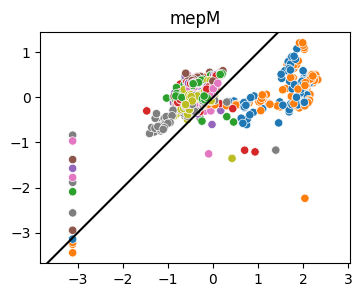

In [687]:
kk = np.random.randint(0,X.shape[1])
kk = adata.var_names.tolist().index('mepM')
fig, ax = plt.subplots(figsize=(4,3))
ax.set_title(adata.var.index.tolist()[kk])
sns.scatterplot(x=X.numpy()[:,kk],
                y=X_hat.detach().numpy()[:,kk],
                hue=adata.obs.strain,
                ax=ax,
                legend=False)
ax.axline((0, 0), slope=1, color='k',)
plt.axis('equal')
plt.show()

In [671]:
ae.eval() 
X_proj = ae.encoder(X).detach().numpy()

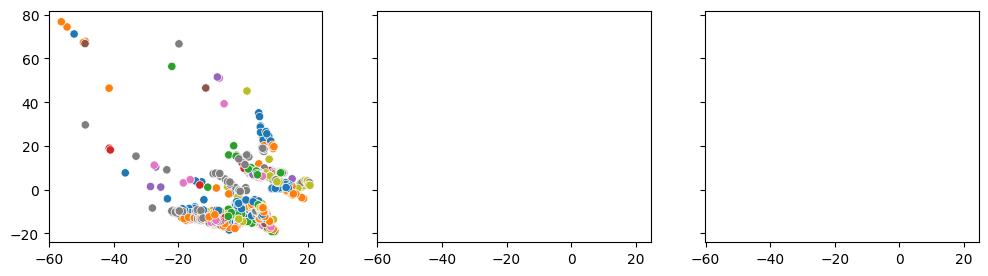

In [672]:
fig, ax = plt.subplots(1,3,figsize=(12,3),sharex=True,sharey=True)
sns.scatterplot(x=X_proj[:,0],y=X_proj[:,1],hue=adata.obs.strain,ax=ax[0],legend=False)
# sns.scatterplot(x=X_proj[:,0],y=X_proj[:,2],hue=adata.obs.strain,ax=ax[1],legend=False)
# g = sns.scatterplot(x=X_proj[:,1],y=X_proj[:,2],hue=adata.obs.strain,ax=ax[2],)
g.legend(frameon=False,loc=(1,0.2))
plt.show()

In [673]:
ae.eval()

this_gene = 'putA'
example = 0 # pBADmin
times = torch.tensor(np.arange(3,21,0.5,dtype=np.float32))
time_response = []
for time in times: 
    p = deepcopy(pert[example]).reshape(1,-1)
    p[:,-3] = time
    X_hat = ae(X[example].reshape(1,-1),p).detach().numpy()
    time_response.append( (X_hat[:,adata.var_names.tolist().index(this_gene)])[0] )
    

12 4104 pBADmin


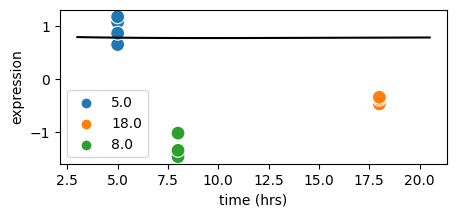

In [674]:
bdata = adata[ (adata.obs.strain.isin(adata[example].obs.strain.tolist())) & 
               (adata.obs.IPTG_concentration.isin(adata[example].obs.IPTG_concentration.tolist())) &
               (adata.obs.arabinose_concentration.isin(adata[example].obs.arabinose_concentration.tolist()))]
print(bdata.n_obs,bdata.n_vars,bdata.obs.strain.unique().tolist()[0])

plt.figure(figsize=(5,2))
sns.scatterplot(x=[float(x) for x in bdata.obs.timepoint.tolist()],
                y=bdata[:,this_gene].X.toarray().reshape(-1),
                hue=bdata.obs.timepoint,
                s=100)

sns.lineplot(x=np.array(times).tolist(),
             y=time_response,
             color='k')

plt.ylabel('expression')
plt.xlabel('time (hrs)')
plt.show()

In [675]:
ae.eval()

this_gene = 'putA'
example = 10 # wild-type
times = torch.tensor(np.arange(3,21,0.5,dtype=np.float32))
time_response = []
for time in times: 
    p = deepcopy(pert[example]).reshape(1,-1)
    p[:,-3] = time
    X_hat = ae(X[example].reshape(1,-1),p).detach().numpy()
    time_response.append( (X_hat[:,adata.var_names.tolist().index(this_gene)])[0] )
    

12 4104 wild-type


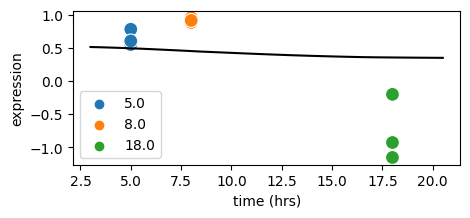

In [676]:
bdata = adata[ (adata.obs.strain.isin(adata[example].obs.strain.tolist())) & 
               (adata.obs.IPTG_concentration.isin(adata[example].obs.IPTG_concentration.tolist())) &
               (adata.obs.arabinose_concentration.isin(adata[example].obs.arabinose_concentration.tolist()))]
print(bdata.n_obs,bdata.n_vars,bdata.obs.strain.unique().tolist()[0])

plt.figure(figsize=(5,2))
sns.scatterplot(x=[float(x) for x in bdata.obs.timepoint.tolist()],
                y=bdata[:,this_gene].X.toarray().reshape(-1),
                hue=bdata.obs.timepoint,
                s=100)

sns.lineplot(x=np.array(times).tolist(),
             y=time_response,
             color='k')

plt.ylabel('expression')
plt.xlabel('time (hrs)')
plt.show()

In [679]:
ae.eval()

this_gene = 'putA'
example = 0 # pBADmin
iptgs = torch.tensor(np.arange(0.0,1,0.05,dtype=np.float32))
dose_response = []
for dose in iptgs: 
    p = deepcopy(pert[example]).reshape(1,-1)
    p[:,-2] = dose # update iptg
    X_hat = ae(X[example].reshape(1,-1),p).detach().numpy()
    dose_response.append( (X_hat[:,adata.var_names.tolist().index(this_gene)])[0] )
    

56 4104 pBADmin


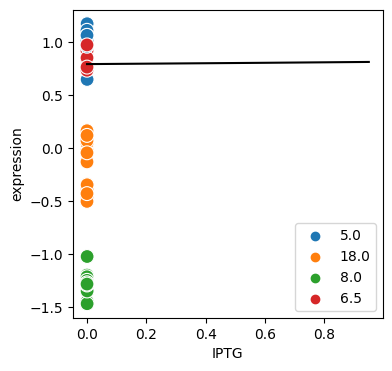

In [680]:
bdata = adata[ (adata.obs.strain.isin(adata[example].obs.strain.tolist())) & 
               (adata.obs.arabinose_concentration.isin(adata[example].obs.arabinose_concentration.tolist()))]
print(bdata.n_obs,bdata.n_vars,bdata.obs.strain.unique().tolist()[0])

plt.figure(figsize=(4,4))
sns.scatterplot(x=bdata.obs.IPTG_concentration.tolist(),
                y=bdata[:,this_gene].X.toarray().reshape(-1),
                hue=bdata.obs.timepoint,
                s=100)

sns.lineplot(x=iptgs,
             y=dose_response,
             color='k')

plt.ylabel('expression')
plt.xlabel('IPTG')
plt.show()